#Bird Classification

This assignment requires participation in a Kaggle competition with the rest of the class on the Caltech-UCSD Birds-200-2011 bird dataset. The objective it to produce a model that
gives the highest possible accuracy on a test dataset containing the same categories.

In other words we have a dataset of birds from several categories, this dataset contains training, testing and validation data. We are going to follow the next steps in order to solve this problematic while having the best accuracy on the validation set.

1.   **Data preprocessing:** we're going to perform the necessary transformations on the dataset from resising croping ect
2.   **Models:** We are going to train multiple models on the data 
3. **Evaluation:** We are going to evaluate the performence of the models and choose the best one to apply to the testing dataset 



##Imports

In [1]:
#general
import numpy as np 
import matplotlib.pyplot as plt 
import math 
import pandas as pd

#files
import zipfile
import os

#data
!pip install imgaug
import imgaug as ia
import imgaug.augmenters as iaa
import torchvision
import torchvision.models as models 
import torchvision.transforms as transforms
from torchvision import datasets

#model
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

#evaluate
import argparse
from tqdm import tqdm
import PIL.Image as Image

#colab 
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/MVA/Object recognition /assignement/assignement_3')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive/


## Global parameters 

In [14]:
#for the data
path_data = './bird_dataset' ## To be changed to specify the folder of the data
threshold = 0.5
#types = ['train' , 'val']
types = [ 'val']
#for models 
num_epochs = 30
batch_size = 32
image_size = 256 
num_classes = 20
features = 512
fmap_size = 8
best_loss = 100 
trigger_times = 0
patience = 5

# Data preprocessing 

In [ ]:
import shutil
path_data = './bird_dataset'
n = 10 # Number of images to add
for clas in os.listdir(path_data + "/train_images"):
  
  i = 0 
  for image in os.listdir(path_data + "/train_images/"+ clas):
    if i < n : 
      pathin = path_data + "/train_images/"+clas
      pathout = path_data + "/val_images/"+clas
      shutil.move(pathin+"/"+image, pathout+"/"+image) ## Used to transfer images from folder to folder 
    i+=1

###Croping the data 

In [ ]:
def crop_image (img) :

  # I will use Mask-RCNN to crop the images 
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  model.eval()

  # Prepare the image 
  transform = transforms.Compose([transforms.ToTensor()])
  img1 = transform(img)

  # Predict the boxes 
  pred = model([img1])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]

  if pred_t != []:
    pred_t = pred_t[-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]

    # Extract bird box 
    if 'bird' in pred_class:
      p = pred_class.index('bird')
      top = math.ceil(pred_boxes[p][0][1])
      left = math.floor(pred_boxes[p][0][0])
      down = math.ceil(pred_boxes[p][1][1])
      right = math.floor(pred_boxes[p][1][0])

      # Crop the image 
      cropped_img = img.crop((left, top, right, down))
      return cropped_img

    else :
      return None 

  else: 
    return None

In [ ]:

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

# Crop images for training and validation data 
for t in types : 
  print(t)
  if t  == 'train' : 
    name = "/train_images"
  else : 
    name = "/val_images"

  for clas in os.listdir(path_data + name):
    class_path = path_data + name + '/' + clas

    for trainim in os.listdir(class_path):
      img_path = class_path +'/'+  trainim 
      img = Image.open(img_path)
      croped = crop_image (img)
      new_path = class_path + '/' + trainim[:-4]+ 'crop.jpg'

      if croped != None :
        print('saved:',new_path)
        croped.save(new_path)

val


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0043_24549crop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0059_25010crop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0083_24967crop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0113_24560crop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0029_24912crop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0089_24841crop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0035_24941crop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0043_24549cropcrop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0059_25010cropcrop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0083_24967cropcrop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Creeper_0113_24560cropcrop.jpg
saved: ./bird_dataset/val_images/028.Brown_Creeper/Brown_Cre

## Dataloaders and data augmentation 

In [3]:
class ImgAugTransform:
  """
  Class to use augmentation from the library imgaug.
  """
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 1.0))),
        iaa.Sometimes(0.25, iaa.CoarseDropout(0.3, size_percent=0.2))
        ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

In [4]:
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20, resample=Image.BILINEAR),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 #std=[0.229, 0.224, 0.225])
])


train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder('./bird_dataset/train_images',transform = data_transforms),
        batch_size=batch_size, shuffle=False, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('./bird_dataset/val_images',transform = data_transforms),
    batch_size=batch_size, shuffle=False, num_workers=1)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('./bird_dataset/test_images',transform = transforms.ToTensor()),
    batch_size=batch_size, shuffle=False, num_workers=1)

### Visualisation 

In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

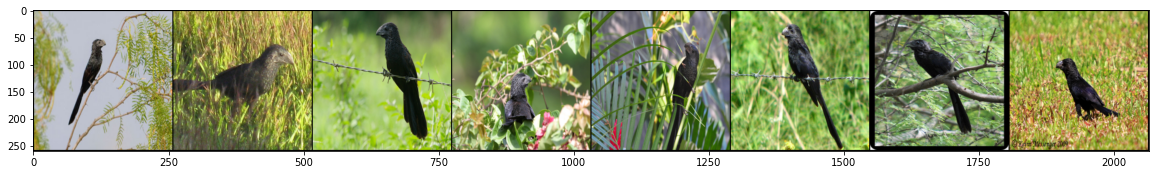

               0                0                0                0                0                0                0                0


In [6]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(20,25))
imshow(torchvision.utils.make_grid(images[9:17]))

# print labels
print(' '.join('%16s' % int(labels[j]) for j in range(8)))

# Model

## Model 1

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

## Model 2

In [8]:
class Resnet50(nn.Module):
  """
  Class that uses ResNet50 and adds two FC layers and two Dropout layers.
  """
  
  def __init__(self):
    super(Resnet50, self).__init__()
    resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    modules = list(resnet.children())[:-1]  # remove the last layer
    self.resnet = nn.Sequential(*modules)
    
    self.linear1 = nn.Linear(resnet.fc.in_features, 1024)
    self.linear2 = nn.Linear(1024, num_classes)
    self.dropout1 = nn.Dropout(p=0.8)
    self.dropout2 = nn.Dropout(p=0.5)
    
  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.size(0), -1)

    x = self.dropout1(x)
    x = F.relu(self.linear1(x))
    
    x = self.dropout2(x)
    x = F.relu(self.linear2(x))

    return x

## Model 3


In [9]:
class Resnet34(nn.Module):
  
    def __init__(self):
        super().__init__()

        # Use a pre-trained model
        self.network = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc =nn.Sequential(
        nn.Linear(num_ftrs,64),
        nn.Tanh(),
        nn.Dropout(0.6),
        nn.Linear(64,num_classes))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

    def forward(self, x):
        return self.network(x)

## Model 4

In [10]:
class ResNet_mult(nn.Module):
  """
  Second class, that can use different networks and not just ResNet50.
  """
  
  def __init__(self, backbone_net):
    super(ResNet_mult, self).__init__()

    self.backbone_name = backbone_net
    if backbone_net == 'resnet50':
      backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    elif backbone_net == 'resnet152':
      backbone = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
    elif backbone_net == 'resnext101_32x8d':
      backbone = models.resnext101_32x8d(weights=models.ResNeXt101_32X8D_Weights.DEFAULT)

    modules = list(backbone.children())[:-1]
    self.backbone = nn.Sequential(*modules)
    
    self.linear1 = nn.Linear(backbone.fc.in_features, 1024)
    self.linear2 = nn.Linear(1024, num_classes)
    self.dropout1 = nn.Dropout(p=0.9)
    self.dropout2 = nn.Dropout(p=0.4)

    self.classifier = nn.Sequential(self.dropout1, self.linear1, self.dropout2, self.linear2)
    
  def forward(self, x):
    x = self.backbone(x)
    x = x.view(x.size(0), -1)

    x = self.dropout1(x)
    x = F.relu(self.linear1(x))
    x = self.dropout2(x)
    x = F.relu(self.linear2(x))

    return x

# Train and validation

## Train and validation functions 

In [11]:
def train(epoch, model , optimizer , log_interval):

    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)

        train_loss += loss.data.item()

        loss.backward()
        optimizer.step()

        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    return (train_loss /len(train_loader.dataset), 100. * correct / len(train_loader.dataset))

In [12]:
def validation(model, epoch):
  
    model.eval()

    validation_loss = 0
    correct = 0

    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()

        # get the index of the max log-probability
        
        pred = output.data.max(1, keepdim=True)[1]
      
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    validation_acc = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),validation_acc))
    
    return validation_loss , validation_acc

## Training model 2

In [13]:
# Lists to store performances 
val_acc_list_2 =[]
val_loss_list_2= []
train_acc_list_2=[]
train_loss_list_2 = []

# Hyperparameters after parameter tuning
hyperparam = {'lr':1e-4, 'w_decay':1e-5, 'step_size' : 20 , 'gamma' : 0.1} 

# Define the model
model = Resnet50() ### The best model 
use_cuda = torch.cuda.is_available()
if torch.cuda.is_available():
  model.cuda()

optimizer = optim.Adam(params=model.parameters(), lr=hyperparam['lr'], weight_decay=hyperparam['w_decay'])
scheduler = StepLR(optimizer, step_size=hyperparam['step_size'], gamma=hyperparam['gamma'])  
loss_func = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs + 1):

    train_loss , train_acc = train(epoch, model , optimizer, 10)
    val_loss , val_acc = validation(model, epoch)
    
    val_acc_list_2.append(val_acc)
    val_loss_list_2.append(val_loss)

    train_acc_list_2.append(train_acc)
    train_loss_list_2.append(train_loss)

    scheduler.step()



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Train Epoch: 1 [0/882 (0%)]	Loss: 3.018395
Train Epoch: 1 [320/882 (36%)]	Loss: 3.013265
Train Epoch: 1 [640/882 (71%)]	Loss: 3.005788

Validation set: Average loss: 0.0989, Accuracy: 12/303 (4%)
Train Epoch: 2 [0/882 (0%)]	Loss: 2.994042
Train Epoch: 2 [320/882 (36%)]	Loss: 2.992224
Train Epoch: 2 [640/882 (71%)]	Loss: 2.998818

Validation set: Average loss: 0.0989, Accuracy: 12/303 (4%)
Train Epoch: 3 [0/882 (0%)]	Loss: 2.990239
Train Epoch: 3 [320/882 (36%)]	Loss: 2.997717
Train Epoch: 3 [640/882 (71%)]	Loss: 2.998415

Validation set: Average loss: 0.0989, Accuracy: 12/303 (4%)
Train Epoch: 4 [0/882 (0%)]	Loss: 2.996005
Train Epoch: 4 [320/882 (36%)]	Loss: 2.998474
Train Epoch: 4 [640/882 (71%)]	Loss: 2.997891

Validation set: Average loss: 0.0989, Accuracy: 15/303 (5%)
Train Epoch: 5 [0/882 (0%)]	Loss: 2.997179
Train Epoch: 5 [320/882 (36%)]	Loss: 2.998599
Train Epoch: 5 [640/882 (71%)]	Loss: 2.999432

Validation set: Average loss: 0.0989, Accuracy: 19/303 (6%)
Train Epoch: 6 [0/88

## Training model 3 

In [16]:
# Lists to store performances 
val_acc_list_3 =[]
val_loss_list_3 = []
train_acc_list_3 =[]
train_loss_list_3 = []

# Hyperparameters after parameter tuning
hyperparam = {'lr':1e-4, 'w_decay':1e-5, 'step_size' : 20 , 'gamma' : 0.1} 

# Define the model
model = Resnet34() ### The best model 
use_cuda = torch.cuda.is_available()
if torch.cuda.is_available():
  model.cuda()

optimizer = optim.Adam(params=model.parameters(), lr=hyperparam['lr'], weight_decay=hyperparam['w_decay'])
scheduler = StepLR(optimizer, step_size=hyperparam['step_size'], gamma=hyperparam['gamma'])  
loss_func = nn.CrossEntropyLoss()

################################ First Part ################################

# Freeze the parameters 
model.freeze()

for epoch in range(1, num_epochs + 1):

    train_loss , train_acc = train(epoch, model , optimizer, 10)
    val_loss , val_acc = validation(model, epoch)
    
    val_acc_list_3.append(val_acc)
    val_loss_list_3.append(val_loss)

    train_acc_list_3.append(train_acc)
    train_loss_list_3.append(train_loss)

    scheduler.step()

################################ Second Part ################################

# Unfreeze the parameters 
model.unfreeze()

for epoch in range(1, num_epochs + 1):

    train_loss , train_acc = train(epoch, model, optimizer, 10)
    val_loss , val_acc = validation(model, epoch)
    
    val_acc_list_3.append(val_acc)
    val_loss_list_3.append(val_loss)

    train_acc_list_3.append(train_acc)
    train_loss_list_3.append(train_loss)

    scheduler.step()
    
    # Early stopping
    if val_loss > best_loss:

      trigger_times += 1
      print('trigger times:', trigger_times)

      if trigger_times >= patience:
        print('Early stopping!\nStart to test process.')
        break

    else:
      print('trigger times: 0')
      trigger_times = 0
    
    best_loss = val_loss

# Save the model 
model_file = './model/' + '/model_' + str(epoch) + '.pth'
torch.save(model.state_dict(), model_file)
#print('Saved model to ' + model_file + '. You can run `python evaluate.py 

Train Epoch: 1 [0/882 (0%)]	Loss: 3.412482
Train Epoch: 1 [320/882 (36%)]	Loss: 2.950628
Train Epoch: 1 [640/882 (71%)]	Loss: 3.401767

Validation set: Average loss: 0.0958, Accuracy: 36/303 (12%)
Train Epoch: 2 [0/882 (0%)]	Loss: 3.042895
Train Epoch: 2 [320/882 (36%)]	Loss: 2.858986
Train Epoch: 2 [640/882 (71%)]	Loss: 3.103226

Validation set: Average loss: 0.0889, Accuracy: 78/303 (26%)
Train Epoch: 3 [0/882 (0%)]	Loss: 3.029592
Train Epoch: 3 [320/882 (36%)]	Loss: 2.798922
Train Epoch: 3 [640/882 (71%)]	Loss: 2.859081

Validation set: Average loss: 0.0844, Accuracy: 114/303 (38%)
Train Epoch: 4 [0/882 (0%)]	Loss: 3.023695
Train Epoch: 4 [320/882 (36%)]	Loss: 2.931058
Train Epoch: 4 [640/882 (71%)]	Loss: 2.677634

Validation set: Average loss: 0.0823, Accuracy: 136/303 (45%)
Train Epoch: 5 [0/882 (0%)]	Loss: 3.013653
Train Epoch: 5 [320/882 (36%)]	Loss: 2.860382
Train Epoch: 5 [640/882 (71%)]	Loss: 2.476757

Validation set: Average loss: 0.0790, Accuracy: 156/303 (51%)
Train Epoch:

FileNotFoundError: ignored

# Evaluate

In [18]:
test_dir = path_data + '/test_images/mistery_category'

test_data_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

model.eval()
output_file = open('kaggle.csv', "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:

        image = pil_loader(test_dir + '/' + f)
        data = test_data_transforms(image)
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()
print('Succesfully wrote kaggle.csv you can upload this file to the kaggle competition website')

100%|██████████| 517/517 [00:15<00:00, 34.19it/s]

Succesfully wrote kaggle.csv you can upload this file to the kaggle competition website
